In [56]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

Populating the interactive namespace from numpy and matplotlib


In [57]:
def create_star_ring_polar(stars, r, vr, vtheta):
    """
    Creates a 'field' of stars (where 'stars' is the desired number of stars) in a ring r distance from the origin
    and returns them in a list. vr and vtheta are the desired initial components of the velocity of every star.
    Each star is defined by a list of four numbers: its initial position components (r and theta), 
    and its initial velocity components (vr and vtheta). Stars are defined using a polar coordinate system.
    """
    import numpy as np
    star_ring = []                                       #creates an empty list
    theta = np.arange(0, 2 * np.pi, (2 * np.pi) / stars)  #creates an array of theta coordinates in a ring around the origin
    for i in theta:                                       #for each theta a star is creates at r
        star_ring.append([r, i, vr, vtheta])     
    return star_ring                                     #each star is added to the list, which is returned at the very end

In [58]:
def create_galaxy(rings, spacing, Rmin, stars, vr, vtheta):
    """
    Creates a galaxy with rings number of rings all evenly spaced at a distnace spacing from each other beginning at distance
    Rmin from the center of the galaxy (which is just the origin). The i-th ring has stars + 6(i-1) number of stars, and each
    star has position and velocity vectors in cartesian coordiantes.
    """
    
    galaxy = []
    for i in range(rings):
        ring = create_star_ring_polar(stars + i*6, (spacing*(i + 2) * Rmin), vr, vtheta)
        for star in ring:
            x = star[0] * np.cos(star[1])
            y = star[0] * np.sin(star[1])
            xv = star[2]*np.cos(star[1]) - star[0]*star[3]*np.sin(star[1])
            yv = star[2]*np.sin(star[1]) + star[0]*star[3]*np.cos(star[1])
            galaxy.append([x, y, xv, yv])
    return galaxy

In [59]:
def plot_galaxy(galaxy):
    """
    Generates a plot of each star in each ring in our galaxy.
    """
    for star in galaxy:
        plt.axis("equal")
        plt.plot(star[0], star[1], 'bo')
    plt.scatter(0, 0, s = 400, c = 'r')                 #plots the center of galaxy, for reference
    plt.show()

In [60]:
Rmin = 25 #kpc
T = 5.442 #time-units (544.2 million years)

galaxy = create_galaxy(5, .1, Rmin, 12, 0, 2 * np.pi / T)

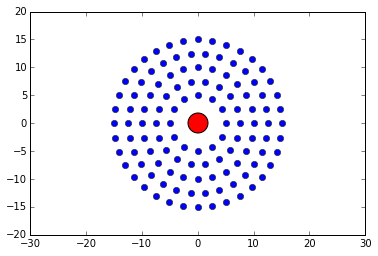

In [100]:
plot_galaxy(galaxy)

In [62]:
#current_locals = [x, y, vx, vy, x_prime, y_prime, vx_prime, vy_prime, M, S]

def three_body(current_locals, t):
    """
    Return the derivatives of the given equation for the position vectors of a star and a disrupting galaxy.
    """
    import numpy as np
    new = np.zeros(8)                                       #initializes an empty array that will hold derivatives
    
    G = 4.5 * (10 ** -8) #kpc^3 solar masses^-1 years^-2    (gravitational constant)                               
    M = current_locals[8]                                   #mass of central galaxy
    S = current_locals[9]                                   #mass of disrupting galaxy
    
    x = current_locals[0]                               #extracts position information for the star
    y = current_locals[1]                              
    r = np.sqrt((x ** 2) + (y ** 2)) 
    
    x_prime = current_locals[4]                               #extracts position information for the disrupting galaxy
    y_prime = current_locals[5]
    R = np.sqrt((x_prime ** 2) + (y_prime ** 2))  
    
    rhox = x_prime - x
    rhoy = y_prime - y
    rho = R - r                                         #calculates distance information between star and disrupting galaxy

    new[0] = current_locals[2]                          #sets new location information equal to current info's derivatives
    new[1] = current_locals[3]
    new[2] = -G * (((M / (r ** 3.)) * x) - ((S / (rho ** 3.)) * rhox) + ((S / (R ** 3.)) * x_prime))
    new[3] = -G * (((M / (r ** 3.)) * y) - ((S / (rho ** 3.)) * rhoy) + ((S / (R ** 3.)) * y_prime))
    new[4] = current_locals[6]
    new[5] = current_locals[7]
    new[6] = -G * (((M + S) / (R ** 3.)) * x_prime)
    new[7] = -G * (((M + S) / (R ** 3.)) * y_prime)
    
    return new

In [77]:
#disruptor = [x_prime, y_prime, vx_prime, vy_prime, S]
#current_locals = [x, y, vx, vy, x_prime, y_prime, vx_prime, vy_prime, M, S]
#galaxy_cartesian = [x, y, vx, vy]

def merge_galaxies(galaxy, disruptor, M, t):
    """
    Takes a star with position (x, y) and velocity (vx, vy) and solves its three-body equations to
    find its locations at all time steps in t. Also returns the positions velocities of the disrupting body.
    """
    import numpy as np
    from scipy.integrate import odeint
    
    star_paths = []
    
    S = disruptor[4]
    for star in galaxy:
        current_loc = [star[0], star[1], star[2], star[3], disruptor[0], disruptor[1], disruptor[2], disruptor[3], M, S]
        loc = current_loc
        
        loc = odeint(three_body, current_loc, t)
    
        xstar = loc[:,0]; ystar = loc[:,1]              #extract the location data of the star's path
        #xvstar = loc[:,2]; yvstar = loc[:,3]
        
        star_paths.append([xstar, ystar])               #store the path of that particular star to a list
    
        xgal = loc[:,4]; ygal = loc[:,5]                #do the same for the disrupting galaxy
        #xvgal = loc[:,6]; yvgal = loc[:,6]
        
        disruptor_path = [xgal, ygal]                   #the disrupting galaxy will have the same path for all stars

    return star_paths, disruptor_path #return vector information for the star and disrupting galaxy

In [96]:
star_paths, disruptor_path = merge_galaxies(galaxy, [10, 3, -1, 0, 6], 10, 100)

In [97]:
def plot_paths(_paths):
    for path in _paths:
        plt.plot(path[0], path[1], 'bo')
    plt.scatter(0, 0, s = 400, c = 'r')    
    plt.show()

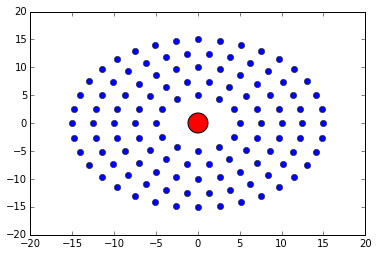

In [98]:
plot_paths(star_paths)